In [65]:
import d3rlpy
import minigrid
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import gymnasium as gym
import dill
from four_room.env import FourRoomsEnv
from four_room.wrappers import gym_wrapper
from four_room.shortest_path import find_all_action_values
from four_room.utils import obs_to_state
import numpy as np

In [66]:
train_config_path = '../four_room/configs/fourrooms_train_config.pl'
reachable_test_config_path = '../four_room/configs/fourrooms_test_100_config.pl'
unreachable_test_config_path = '../four_room/configs/fourrooms_test_0_config.pl'

In [67]:
def get_config(path):
    with open('../four_room/configs/fourrooms_train_config.pl', 'rb') as file:
        train_config = dill.load(file)
    file.close()
    return train_config

In [91]:
'''
Generates a dataset from the tasks specified in config. Size of returned dataset thus depends on amount of tasks
specified in config as well as on the quality of the policy used to generate the dataset. If step_limit=True is
used as argument the generation of data samples is stopped after num_steps steps. If all task in config are
completed before num_steps a smaller dataset is returned. The policy argument takes an int, where 0=expert,
1=random.
'''
def get_dataset_from_config(config, policy=0, step_limit=False, num_steps=1000):

    env = gym_wrapper(gym.make('MiniGrid-FourRooms-v1',
                               agent_pos=config['agent positions'],
                               goal_pos=config['goal positions'],
                               doors_pos=config['topologies'],
                               agent_dir=config['agent directions']))

    num_of_tasks = len(config['agent positions'])
    tasks_seen = 0

    observation, info = env.reset()
    tasks_seen += 1

    dataset = {'observations': [], 'next_observations': [], 'actions': [], 'rewards': [],
               'terminals': [], 'timeouts': [], 'infos': []}

    count = 0
    while not (step_limit and num_steps < count):  # stops if there is a step_limit and it is exceeded
        count += 1

        if policy == 0:
            state = obs_to_state(observation)
            q_values = find_all_action_values(state[:2], state[2], state[3:5], state[5:], 0.99)
            action = np.argmax(q_values)
        elif policy == 1:
            action = env.action_space.sample()
        else:
            # implement default behaviour or return error, for now just uses random policy
            action = env.action_space.sample()

        last_observation = observation
        observation, reward, terminated, truncated, info = env.step(action)

        dataset['observations'].append(np.array(last_observation).flatten())
        dataset['next_observations'].append(np.array(observation).flatten())
        dataset['actions'].append(np.array([action]))
        dataset['rewards'].append(reward)
        dataset['terminals'].append(terminated)
        dataset['timeouts'].append(truncated)
        dataset['infos'].append(info)

        if terminated or truncated:
            if tasks_seen == num_of_tasks:
                env.close()
                break
            observation, info = env.reset()
            tasks_seen += 1

    for key in dataset:
        dataset[key] = np.array(dataset[key])
    return dataset

In [92]:
def get_expert_dataset_from_config(config, step_limit=False, num_steps=1000):
    return get_dataset_from_config(config, policy=0, step_limit=step_limit, num_steps=num_steps)

In [93]:
def get_random_dataset_from_config(config, step_limit=False, num_steps=1000):
    return get_dataset_from_config(config, policy=1, step_limit=step_limit, num_steps=num_steps)

In [89]:
config = get_config(unreachable_test_config_path)

dataset = get_random_dataset_from_config(config)

num_tasks = len(config['agent positions'])
num_steps = len(dataset['observations'])

print('#tasks = ', num_tasks)
print('#steps = ', num_steps)

#tasks =  40
#steps =  3817


In [9]:
train_dataset = four_room.fourrooms_dataset_gen.get_expert_dataset(800)
test_dataset = four_room.fourrooms_dataset_gen.get_expert_dataset(200)

train_dataset = d3rlpy.dataset.MDPDataset(
    observations=train_dataset.get("observations"),
    actions=train_dataset.get("actions"),
    rewards=train_dataset.get("rewards"),
    terminals=train_dataset.get("terminals"),
)

test_dataset = d3rlpy.dataset.MDPDataset(
    observations=test_dataset.get("observations"),
    actions=test_dataset.get("actions"),
    rewards=test_dataset.get("rewards"),
    terminals=test_dataset.get("terminals"),
)

2024-05-07 15:38.57 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]) observation_signature=Signature(dtype=[dtype('float64')], shape=[(324,)]) reward_signature=Signature(dtype=[dtype('int32')], shape=[(1,)])
2024-05-07 15:38.57 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2024-05-07 15:38.57 [info     ] Action size has been automatically determined. action_size=3
2024-05-07 15:38.57 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]) observation_signature=Signature(dtype=[dtype('float64')], shape=[(324,)]) reward_signature=Signature(dtype=[dtype('int32')], shape=[(1,)])
2024-05-07 15:38.57 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.DISCRETE: 2>
2024-05-07 15:38.57 [info     ] Action size has been automatically determined. action_size=3


In [6]:
env = FourRoomsEnv()

In [16]:
# setup algorithm
cql = d3rlpy.algos.DiscreteCQLConfig().create()

# start offline training
cql.fit(train_dataset,
        evaluators={"metric_td_error": d3rlpy.metrics.TDErrorEvaluator(),
                    "metric_discrete_action_match": d3rlpy.metrics.DiscreteActionMatchEvaluator()},
        n_steps=10000,
        n_steps_per_epoch=2000)

2024-05-07 15:59.32 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float64')], shape=[(324,)]), action_signature=Signature(dtype=[dtype('int64')], shape=[(1,)]), reward_signature=Signature(dtype=[dtype('int32')], shape=[(1,)]), action_space=<ActionSpace.DISCRETE: 2>, action_size=3)
2024-05-07 15:59.32 [info     ] Directory is created at d3rlpy_logs\DiscreteCQL_20240507155932
2024-05-07 15:59.32 [debug    ] Building models...            
2024-05-07 15:59.32 [debug    ] Models have been built.       
2024-05-07 15:59.33 [info     ] Parameters                     params={'observation_shape': [324], 'action_size': 3, 'config': {'type': 'discrete_cql', 'params': {'batch_size': 32, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'learning_rate': 6.25e-05, 'optim_factory': {'type': 'adam', 'params': {'betas': 

Epoch 1/5:   0%|          | 0/2000 [00:00<?, ?it/s]

2024-05-07 15:59.57 [info     ] DiscreteCQL_20240507155932: epoch=1 step=2000 epoch=1 metrics={'time_sample_batch': 0.002813942551612854, 'time_algorithm_update': 0.009107040166854858, 'loss': 0.7980378549546003, 'td_loss': 0.07267564485128969, 'conservative_loss': 0.7253622107356786, 'time_step': 0.012051542162895203, 'metric_td_error': 0.2157160777083979, 'metric_discrete_action_match': 0.7972465581977471} step=2000
2024-05-07 15:59.57 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteCQL_20240507155932\model_2000.d3


Epoch 2/5:   0%|          | 0/2000 [00:00<?, ?it/s]

2024-05-07 16:00.24 [info     ] DiscreteCQL_20240507155932: epoch=2 step=4000 epoch=2 metrics={'time_sample_batch': 0.002887028932571411, 'time_algorithm_update': 0.009747663736343384, 'loss': 0.36401506954059004, 'td_loss': 0.028239232210209592, 'conservative_loss': 0.3357758374400437, 'time_step': 0.012782542943954468, 'metric_td_error': 0.18243883386163526, 'metric_discrete_action_match': 0.9949937421777222} step=4000
2024-05-07 16:00.24 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteCQL_20240507155932\model_4000.d3


Epoch 3/5:   0%|          | 0/2000 [00:00<?, ?it/s]

2024-05-07 16:01.23 [info     ] DiscreteCQL_20240507155932: epoch=4 step=8000 epoch=4 metrics={'time_sample_batch': 0.0036425143480300903, 'time_algorithm_update': 0.01164262318611145, 'loss': 0.035478820495773104, 'td_loss': 0.006278267535089981, 'conservative_loss': 0.029200552944093943, 'time_step': 0.015456988096237183, 'metric_td_error': 0.13933725038621567, 'metric_discrete_action_match': 1.0} step=8000
2024-05-07 16:01.23 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteCQL_20240507155932\model_8000.d3


Epoch 5/5:   0%|          | 0/2000 [00:00<?, ?it/s]

2024-05-07 16:01.56 [info     ] DiscreteCQL_20240507155932: epoch=5 step=10000 epoch=5 metrics={'time_sample_batch': 0.003772738575935364, 'time_algorithm_update': 0.012200772166252136, 'loss': 0.014182602640823461, 'td_loss': 0.0039158343615417835, 'conservative_loss': 0.010266768272675109, 'time_step': 0.016146977543830873, 'metric_td_error': 0.1280818070551048, 'metric_discrete_action_match': 1.0} step=10000
2024-05-07 16:01.56 [info     ] Model parameters are saved to d3rlpy_logs\DiscreteCQL_20240507155932\model_10000.d3


[(1,
  {'time_sample_batch': 0.002813942551612854,
   'time_algorithm_update': 0.009107040166854858,
   'loss': 0.7980378549546003,
   'td_loss': 0.07267564485128969,
   'conservative_loss': 0.7253622107356786,
   'time_step': 0.012051542162895203,
   'metric_td_error': 0.2157160777083979,
   'metric_discrete_action_match': 0.7972465581977471}),
 (2,
  {'time_sample_batch': 0.002887028932571411,
   'time_algorithm_update': 0.009747663736343384,
   'loss': 0.36401506954059004,
   'td_loss': 0.028239232210209592,
   'conservative_loss': 0.3357758374400437,
   'time_step': 0.012782542943954468,
   'metric_td_error': 0.18243883386163526,
   'metric_discrete_action_match': 0.9949937421777222}),
 (3,
  {'time_sample_batch': 0.0029916235208511353,
   'time_algorithm_update': 0.009985337257385254,
   'loss': 0.11478013947419823,
   'td_loss': 0.017309898683335632,
   'conservative_loss': 0.09747024079225958,
   'time_step': 0.013128781914710999,
   'metric_td_error': 0.15758154227349477,
   'm

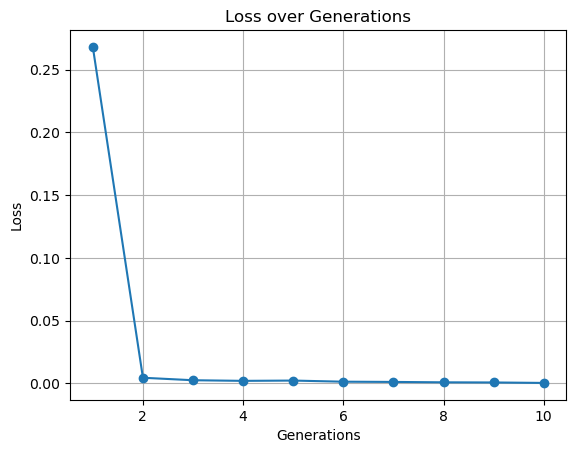

In [1]:
data_str = '''
[(1,
  {'time_sample_batch': 0.002453571367263794,
   'time_algorithm_update': 0.008095146250724793,
   'loss': 0.26805083905658683,
   'td_loss': 0.028214070072909818,
   'conservative_loss': 0.23983676906349138,
   'time_step': 0.010789391541481019}),
 (2,
  {'time_sample_batch': 0.0026196724891662596,
   'time_algorithm_update': 0.008502544212341308,
   'loss': 0.00442748624390224,
   'td_loss': 0.0020811191182809126,
   'conservative_loss': 0.0023463671271834754,
   'time_step': 0.011384639143943786}),
 (3,
  {'time_sample_batch': 0.0026601959228515627,
   'time_algorithm_update': 0.008795037937164307,
   'loss': 0.0024433221404324286,
   'td_loss': 0.0018449234426145267,
   'conservative_loss': 0.0005983986965155054,
   'time_step': 0.01171650288105011}),
 (4,
  {'time_sample_batch': 0.0026230920791625975,
   'time_algorithm_update': 0.008671077847480774,
   'loss': 0.001946176831322373,
   'td_loss': 0.0016005617132417683,
   'conservative_loss': 0.0003456151181773748,
   'time_step': 0.01155380618572235}),
 (5,
  {'time_sample_batch': 0.0023678970336914063,
   'time_algorithm_update': 0.007757962155342102,
   'loss': 0.002180829712114064,
   'td_loss': 0.001928035513881332,
   'conservative_loss': 0.0002527941971202381,
   'time_step': 0.010353169536590576}),
 (6,
  {'time_sample_batch': 0.0024223738431930542,
   'time_algorithm_update': 0.007932768154144287,
   'loss': 0.0012808308376130299,
   'td_loss': 0.001124828100625382,
   'conservative_loss': 0.00015600273776690302,
   'time_step': 0.010581687355041504}),
 (7,
  {'time_sample_batch': 0.0023287145137786867,
   'time_algorithm_update': 0.0076536212682724,
   'loss': 0.0010928242479749314,
   'td_loss': 0.000987476016994151,
   'conservative_loss': 0.00010534823082271032,
   'time_step': 0.010198658752441405}),
 (8,
  {'time_sample_batch': 0.0024859055280685425,
   'time_algorithm_update': 0.008131403374671936,
   'loss': 0.000782717349694758,
   'td_loss': 0.0007138595239312053,
   'conservative_loss': 6.885782509998535e-05,
   'time_step': 0.010864242696762085}),
 (9,
  {'time_sample_batch': 0.0031290735244750975,
   'time_algorithm_update': 0.010494501042366027,
   'loss': 0.0006659229309823786,
   'td_loss': 0.0006155338401653808,
   'conservative_loss': 5.038909053382667e-05,
   'time_step': 0.013914334535598755}),
 (10,
  {'time_sample_batch': 0.0024770496129989626,
   'time_algorithm_update': 0.008308553409576416,
   'loss': 0.00030445473760623825,
   'td_loss': 0.0002846679988856522,
   'conservative_loss': 1.9786738651055204e-05,
   'time_step': 0.01101419837474823})]
'''

# Evaluate the string to convert it into a list of tuples
data = eval(data_str)

# Extract generations and losses
generations = [d[0] for d in data]
losses = [d[1]['loss'] for d in data]

# Plotting
plt.plot(generations, losses, marker='o', linestyle='-')
plt.xlabel('Generations')
plt.ylabel('Loss')
plt.title('Loss over Generations')
plt.grid(True)
plt.show()


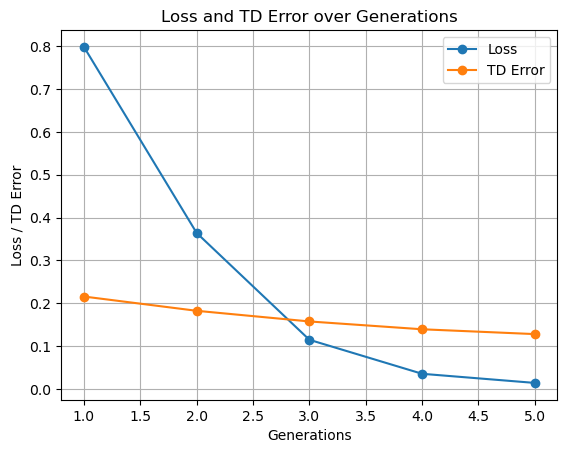

In [17]:
data_str = '''
[(1,
  {'time_sample_batch': 0.002813942551612854,
   'time_algorithm_update': 0.009107040166854858,
   'loss': 0.7980378549546003,
   'td_loss': 0.07267564485128969,
   'conservative_loss': 0.7253622107356786,
   'time_step': 0.012051542162895203,
   'metric_td_error': 0.2157160777083979,
   'metric_discrete_action_match': 0.7972465581977471}),
 (2,
  {'time_sample_batch': 0.002887028932571411,
   'time_algorithm_update': 0.009747663736343384,
   'loss': 0.36401506954059004,
   'td_loss': 0.028239232210209592,
   'conservative_loss': 0.3357758374400437,
   'time_step': 0.012782542943954468,
   'metric_td_error': 0.18243883386163526,
   'metric_discrete_action_match': 0.9949937421777222}),
 (3,
  {'time_sample_batch': 0.0029916235208511353,
   'time_algorithm_update': 0.009985337257385254,
   'loss': 0.11478013947419823,
   'td_loss': 0.017309898683335632,
   'conservative_loss': 0.09747024079225958,
   'time_step': 0.013128781914710999,
   'metric_td_error': 0.15758154227349477,
   'metric_discrete_action_match': 1.0}),
 (4,
  {'time_sample_batch': 0.0036425143480300903,
   'time_algorithm_update': 0.01164262318611145,
   'loss': 0.035478820495773104,
   'td_loss': 0.006278267535089981,
   'conservative_loss': 0.029200552944093943,
   'time_step': 0.015456988096237183,
   'metric_td_error': 0.13933725038621567,
   'metric_discrete_action_match': 1.0}),
 (5,
  {'time_sample_batch': 0.003772738575935364,
   'time_algorithm_update': 0.012200772166252136,
   'loss': 0.014182602640823461,
   'td_loss': 0.0039158343615417835,
   'conservative_loss': 0.010266768272675109,
   'time_step': 0.016146977543830873,
   'metric_td_error': 0.1280818070551048,
   'metric_discrete_action_match': 1.0})]
'''

# Evaluate the string to convert it into a list of tuples
data = eval(data_str)

# Extract generations, losses, and TD errors
generations = [d[0] for d in data]
losses = [d[1]['loss'] for d in data]
td_errors = [d[1]['metric_td_error'] for d in data]

# Plotting
plt.plot(generations, losses, marker='o', linestyle='-', label='Loss')
plt.plot(generations, td_errors, marker='o', linestyle='-', label='TD Error')
plt.xlabel('Generations')
plt.ylabel('Loss / TD Error')
plt.title('Loss and TD Error over Generations')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
train_episodes, test_episodes = train_test_split(dataset, test_size=0.2)

TypeError: Singleton array array(<d3rlpy.dataset.replay_buffer.ReplayBuffer object at 0x000001ED248B1420>,
      dtype=object) cannot be considered a valid collection.